In [109]:
#EXTRACTION PHASE

In [110]:
sc

In [111]:
#Spark Imports
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf

#Create an sqlContext with a default of 20 partitions
spark=SparkSession.builder.appName('Sample').getOrCreate()
sqlContext.sql("set spark.sql.shuffle.partitions=20")

DataFrame[key: string, value: string]

In [112]:
#Read datasources into Spark Dataframes
lol = spark.read.csv('LeagueofLegends.csv', header='true', inferSchema='true')
kills = spark.read.csv('kills.csv', header='true', inferSchema='true')
gold = spark.read.csv('gold.csv', header='true', inferSchema='true')

In [113]:
#TRANSFORMATION PHASE

In [114]:
#Join kills & main dataframe together
df=lol.join(kills,'Address', how='inner')
df.show(1)

+--------------------+------+----+------+--------+-----------+-------+-------+----------+----------+--------------------+--------------------+--------------------+--------------------+-------+--------+-------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------+-------+------------+--------------------+----------+---------------+--------------------+----------+---------------+--------------------+---------+------------+--------------------+-----------+----------------+--------------------+--------------------+------+-----------+--------------------+---------+--------------+--------------------+---------+--------------+--------------------+-------+-----------+--------------------+----------+---------------+--------------------+--------------------+------+-----+-----------+--------+--------+--------+--------+--------+-----+-----+
|             Address|League|Year|Season|    Type|blueTeamTag|bResult|

In [115]:
#Drop all irrelevant columns
drop_list = ['League', 'Season', 'Type', 'Year', 'golddiff', 'goldblue', 'goldred',
             'blueTop', 'blueTopChamp', 'goldblueTop', 'blueJungle', 'blueJungleChamp', 'goldblueJungle', 'blueMiddle', 
             'blueMiddleChamp', 'goldblueMiddle', 'blueADC', 'blueADCChamp', 'goldblueADC', 'blueSupport', 'blueSupportChamp',
             'goldblueSupport', 'blueBans',
             'redTop', 'redTopChamp', 'goldredTop', 'redJungle', 'redJungleChamp', 'goldredJungle', 'redMiddle', 
             'redMiddleChamp', 'goldredMiddle', 'redADC', 'redADCChamp', 'goldredADC', 'redSupport', 'redSupportChamp',
             'goldredSupport', 'redBans',
             'rKills', 'bKills', 'Team', 'Time', 'Victim', 'Killer', 'Assist_1', 'Assist_2', 'Assist_3', 'Assist_4']

df = df.select([column for column in df.columns if column not in drop_list])

In [116]:
#Shows missing values
from pyspark.sql.functions import *
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show(1)

+-------+-----------+-------+-------+----------+----------+-------+-------+--------+-------+--------+-------+-------+--------+-------+--------+-----+-----+
|Address|blueTeamTag|bResult|rResult|redTeamTag|gamelength|bTowers|bInhibs|bDragons|bBarons|bHeralds|rTowers|rInhibs|rDragons|rBarons|rHeralds|x_pos|y_pos|
+-------+-----------+-------+-------+----------+----------+-------+-------+--------+-------+--------+-------+-------+--------+-------+--------+-----+-----+
|      0|        896|      0|      0|       848|         0|      0|      0|       0|      0|       0|      0|      0|       0|      0|       0|  113|  113|
+-------+-----------+-------+-------+----------+----------+-------+-------+--------+-------+--------+-------+-------+--------+-------+--------+-----+-----+



In [117]:
#Remove rows with null values
df = df.filter(df.blueTeamTag.isNotNull()).filter(df.redTeamTag.isNotNull()).filter(df.x_pos. isNotNull())

In [118]:
from pyspark.sql.functions import col, size, split

#Found consistencies in the data relating to the naming of objectives
#Counts the given value and replaces the current array data with that count
df = df.withColumn('rTowers', size(split(col("rTowers"), "TOWER")))
df = df.withColumn('bTowers', size(split(col("bTowers"), "TOWER")))
df = df.withColumn('bInhibs', size(split(col("bInhibs"), "LANE")))
df = df.withColumn('rInhibs', size(split(col("rInhibs"), "LANE")))
df = df.withColumn('bDragons', size(split(col("bDragons"), "DRAGON")))
df = df.withColumn('rDragons', size(split(col("rDragons"), "DRAGON")))

df.show(1)

+--------------------+-----------+-------+-------+----------+----------+-------+-------+--------+-------+--------+-------+-------+--------+-------------------+--------+-----+-----+
|             Address|blueTeamTag|bResult|rResult|redTeamTag|gamelength|bTowers|bInhibs|bDragons|bBarons|bHeralds|rTowers|rInhibs|rDragons|            rBarons|rHeralds|x_pos|y_pos|
+--------------------+-----------+-------+-------+----------+----------+-------+-------+--------+-------+--------+-------+-------+--------+-------------------+--------+-----+-----+
|http://matchhisto...|        PNG|      0|      1|       RED|        34|      1|      1|       1|     []|      []|      1|      4|       5|[[25.446], [32.58]]|      []| 8680| 8457|
+--------------------+-----------+-------+-------+----------+----------+-------+-------+--------+-------+--------+-------+-------+--------+-------------------+--------+-----+-----+
only showing top 1 row



In [119]:
#Problematic assigned data types. Most arrays have automatically been assigned as strings as well as numerical data
df.printSchema()

root
 |-- Address: string (nullable = true)
 |-- blueTeamTag: string (nullable = true)
 |-- bResult: integer (nullable = true)
 |-- rResult: integer (nullable = true)
 |-- redTeamTag: string (nullable = true)
 |-- gamelength: integer (nullable = true)
 |-- bTowers: integer (nullable = false)
 |-- bInhibs: integer (nullable = false)
 |-- bDragons: integer (nullable = false)
 |-- bBarons: string (nullable = true)
 |-- bHeralds: string (nullable = true)
 |-- rTowers: integer (nullable = false)
 |-- rInhibs: integer (nullable = false)
 |-- rDragons: integer (nullable = false)
 |-- rBarons: string (nullable = true)
 |-- rHeralds: string (nullable = true)
 |-- x_pos: string (nullable = true)
 |-- y_pos: string (nullable = true)



In [120]:
#Function used to cast columns as the given type and remove any brackets using regex
def convertColumnType(df, names, newType):
    for name in names: 
        if newType == "array<int>":
            df = df.withColumn(name, split(regexp_replace(name, r"(^\[\[)|(\]\]$)", ""), ", ").cast("array<int>"))
        else:
            df = df.withColumn(name, df[name].cast(newType))
    return df

In [121]:
#Arrays holding values to be used with the convertColumnType function
toInt = ['rTowers', 'bTowers', 'bInhibs', 'rInhibs', 'bDragons', 'rDragons', 'x_pos', 'y_pos']

#Casting these columns to array allows for array manipulation in later transformations
toArray = ['rBarons', 'bBarons', 'rHeralds', 'bHeralds']

df = convertColumnType(df, toArray, "array<int>")
df = convertColumnType(df, toInt, "int")

df.printSchema()
df.show(1)

root
 |-- Address: string (nullable = true)
 |-- blueTeamTag: string (nullable = true)
 |-- bResult: integer (nullable = true)
 |-- rResult: integer (nullable = true)
 |-- redTeamTag: string (nullable = true)
 |-- gamelength: integer (nullable = true)
 |-- bTowers: integer (nullable = false)
 |-- bInhibs: integer (nullable = false)
 |-- bDragons: integer (nullable = false)
 |-- bBarons: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- bHeralds: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- rTowers: integer (nullable = false)
 |-- rInhibs: integer (nullable = false)
 |-- rDragons: integer (nullable = false)
 |-- rBarons: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- rHeralds: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- x_pos: integer (nullable = true)
 |-- y_pos: integer (nullable = true)

+--------------------+-----------+-------+-------+----------+----------+-

In [122]:
#Function designed for counting array elements and casting the result an int
def countArrayElements(df, names):
    for name in names: 
            df = df.withColumn(name, size(name).cast('int'))
    return df

In [123]:
#Count the array entries for these variables as they have no unique string occurence like in the dragon columns for instance
arrayObjects = ['rBarons', 'bBarons', 'rHeralds', 'bHeralds']
df = countArrayElements(df, arrayObjects)

In [126]:
#Much cleaner dataset
df.show(1)

+--------------------+-----------+-------+-------+----------+----------+-------+-------+--------+-------+--------+-------+-------+--------+-------+--------+-----+-----+
|             Address|blueTeamTag|bResult|rResult|redTeamTag|gamelength|bTowers|bInhibs|bDragons|bBarons|bHeralds|rTowers|rInhibs|rDragons|rBarons|rHeralds|x_pos|y_pos|
+--------------------+-----------+-------+-------+----------+----------+-------+-------+--------+-------+--------+-------+-------+--------+-------+--------+-----+-----+
|http://matchhisto...|        PNG|      0|      1|       RED|        34|      1|      1|       1|      1|       1|      1|      4|       5|      2|       1| 8680| 8457|
+--------------------+-----------+-------+-------+----------+----------+-------+-------+--------+-------+--------+-------+-------+--------+-------+--------+-----+-----+
only showing top 1 row



In [128]:
#All types are correctly assigned
df.printSchema()

root
 |-- Address: string (nullable = true)
 |-- blueTeamTag: string (nullable = true)
 |-- bResult: integer (nullable = true)
 |-- rResult: integer (nullable = true)
 |-- redTeamTag: string (nullable = true)
 |-- gamelength: integer (nullable = true)
 |-- bTowers: integer (nullable = false)
 |-- bInhibs: integer (nullable = false)
 |-- bDragons: integer (nullable = false)
 |-- bBarons: integer (nullable = false)
 |-- bHeralds: integer (nullable = false)
 |-- rTowers: integer (nullable = false)
 |-- rInhibs: integer (nullable = false)
 |-- rDragons: integer (nullable = false)
 |-- rBarons: integer (nullable = false)
 |-- rHeralds: integer (nullable = false)
 |-- x_pos: integer (nullable = true)
 |-- y_pos: integer (nullable = true)



In [ ]:
#LOAD PHASE

In [129]:
#Write to mongodb
df.write.format("com.mongodb.spark.sql.DefaultSource") \
.mode("append") \
.option("database","test") \
.option("collection", "league").save()

gold.write.format("com.mongodb.spark.sql.DefaultSource") \
.mode("append") \
.option("database","test") \
.option("collection", "gold").save()

In [130]:
#Import MongoClient to interact with saved MongoDB
import pymongo
from pymongo import MongoClient
client = MongoClient()

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#VISUALISATION PHASE

In [132]:
#Test mongodb
result = client.test.league.find()
lol= pd.DataFrame(list(result))
lol.head(3)

,Address,_id,bBarons,bDragons,bHeralds,bInhibs,bResult,bTowers,blueTeamTag,gamelength,rBarons,rDragons,rHeralds,rInhibs,rResult,rTowers,redTeamTag,x_pos,y_pos
0,http://matchhistory.br.leagueoflegends.com/pt/...,5ccc76eee88b100c0a83d08f,1,1,1,1,0,1,PNG,34,2,1,1,1,1,1,RED,8680.0,8457.0
1,http://matchhistory.br.leagueoflegends.com/pt/...,5ccc76eee88b100c0a83d090,1,1,1,1,0,1,PNG,34,2,1,1,1,1,1,RED,3526.0,8168.0
2,http://matchhistory.br.leagueoflegends.com/pt/...,5ccc76eee88b100c0a83d091,1,1,1,1,0,1,PNG,34,2,1,1,1,1,1,RED,2805.0,3392.0


In [133]:
#Create seperate DF for wins analysis
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = lol.copy(deep=True)
df['win_team'] = np.where(df['bResult']==1, 'blue', 'red')
df[['win_team', 'bResult', 'rResult']].head(2)

,win_team,bResult,rResult
0,red,0,1
1,red,0,1


In [134]:
#Generate a sample game 
sampleGame = lol.loc[lol['Address'] == "http://matchhistory.na.leagueoflegends.com/en/#match-details/TRLH1/30030?gameHash=fbb300951ad8327c"]

In [135]:
#Grab a sample team 'TSM', both their play history on both sides of the map
tsmBlueSide = lol.loc[lol['blueTeamTag'] == "TSM"]
tsmRedSide = lol.loc[lol['redTeamTag'] == "TSM"]

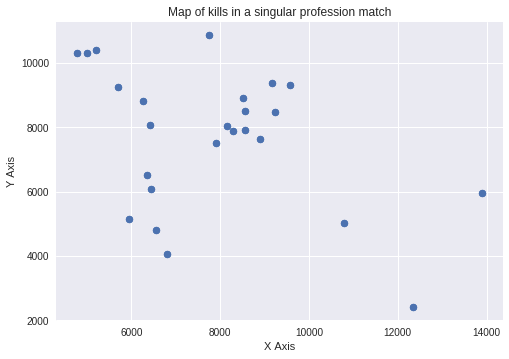

In [136]:
#Map a sample games kills
#As we can see most kills appeared on the top side of the map
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(sampleGame.x_pos, sampleGame.y_pos)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
plt.title("Map of kills in a singular profession match")
plt.show() 

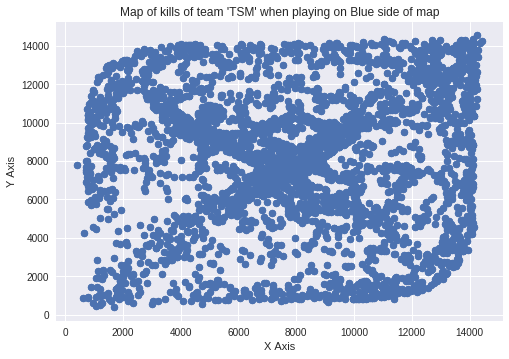

In [137]:
#Sample kill map of the team 'TSM' when playing blue side
#The map looks almost identical to the actual map the game is played on
fig, ax = plt.subplots()
ax.scatter(tsmBlueSide.x_pos, tsmBlueSide.y_pos)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
plt.title("Map of kills of team 'TSM' when playing on Blue side of map")
plt.show() 

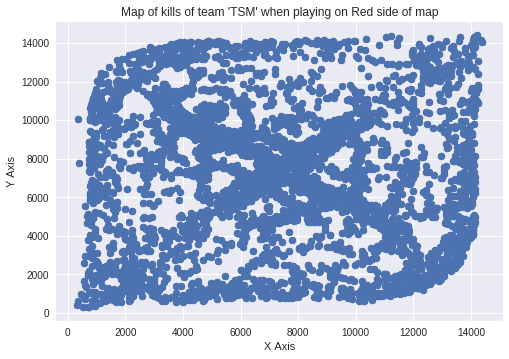

In [138]:
#Sample kill map of the team 'TSM' when playing red side
#More kills appear to be present in the opposite teams base in both instances, 
#suggesting they are playing successfully over their entire play history

fig, ax = plt.subplots()
ax.scatter(tsmRedSide.x_pos, tsmRedSide.y_pos)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
plt.title("Map of kills of team 'TSM' when playing on Red side of map")
plt.show() 

('Max game length:', 95)
('Min game length:', 17)
('Mean game length:', 37.99868462590761)


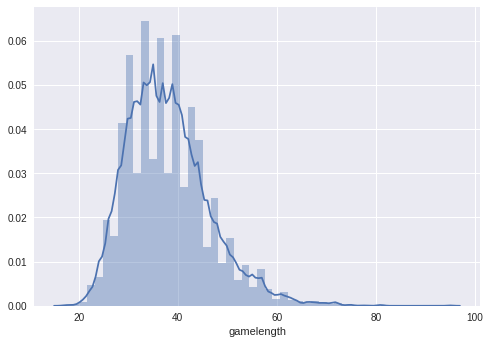

In [139]:
#Generate overall game length data
print('Max game length:', df.gamelength.max())
print('Min game length:', df.gamelength.min())
print('Mean game length:', df.gamelength.mean())
sns.distplot(df.gamelength)
plt.show()

('Max game length:', 63)
('Min game length:', 23)
('Mean game length:', 36.93126022913257)


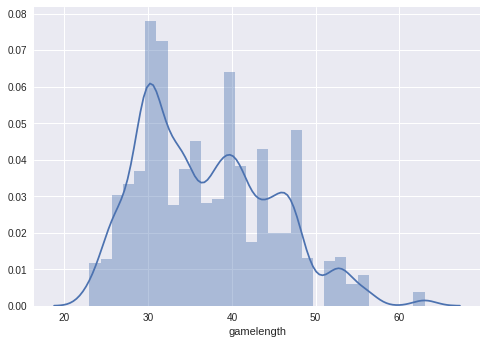

In [140]:
#Generate average game length of team 'TSM' while playing on blueside (regardless of win/loss)
print('Max game length:', tsmBlueSide.gamelength.max())
print('Min game length:', tsmBlueSide.gamelength.min())
print('Mean game length:', tsmBlueSide.gamelength.mean())
sns.distplot(tsmBlueSide.gamelength)
plt.show()

('Max game length:', 58)
('Min game length:', 25)
('Mean game length:', 37.724137931034484)


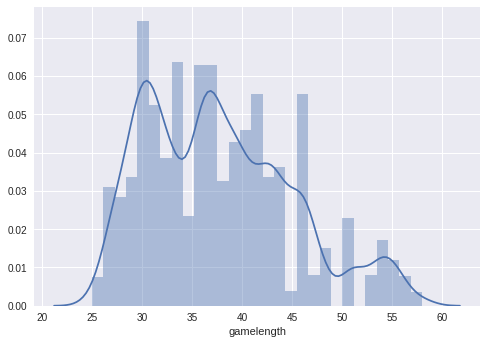

In [141]:
#Generate average game length of team 'TSM' while playing on redside (regardless of win/loss)
#It seems on average the team play longer games while playing on red side
print('Max game length:', tsmRedSide.gamelength.max())
print('Min game length:', tsmRedSide.gamelength.min())
print('Mean game length:', tsmRedSide.gamelength.mean())
sns.distplot(tsmRedSide.gamelength)
plt.show()

In [142]:
#See if blue side really does win more games
print("Number of Blue Wins", df.bResult.sum())
print("Number of Red Wins", df.rResult.sum())

('Number of Blue Wins', 203140L)
('Number of Red Wins', 176980L)


In [143]:
#Create a seperate dataframe for win comparison
team_comparison = pd.DataFrame(data={'asRed': df.redTeamTag.value_counts(),
                                     'asRedWins': df.groupby('redTeamTag').rResult.sum(),
                                     'asBlue': df.blueTeamTag.value_counts(),
                                     'asBlueWins': df.groupby('blueTeamTag').bResult.sum()})

In [144]:
#Calculate total games and win percentage for each side
team_comparison['totalGames'] = team_comparison.asBlue + team_comparison.asRed
team_comparison['blueWinPct'] = team_comparison.asBlueWins / team_comparison.asBlue
team_comparison['redWinPct'] = team_comparison.asRedWins / team_comparison.asRed
team_comparison.head()

,asBlue,asBlueWins,asRed,asRedWins,totalGames,blueWinPct,redWinPct
100,102.0,102.0,46.0,0.0,148.0,1.000000,0.000000
17A,208.0,68.0,208.0,70.0,416.0,0.326923,0.336538
7h,1588.0,910.0,1778.0,670.0,3366.0,0.573048,0.376828
A,1030.0,382.0,1036.0,442.0,2066.0,0.370874,0.426641
AE,2170.0,902.0,2004.0,594.0,4174.0,0.415668,0.296407


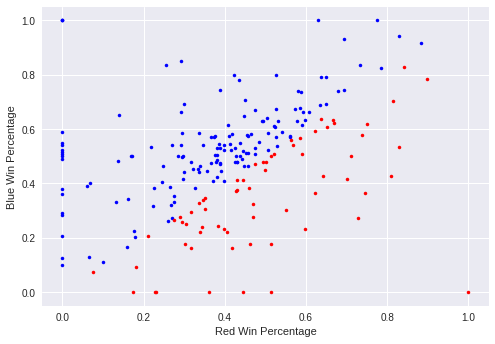

In [145]:
#It seems blue side does indeed win more frequently on average
blueWin = team_comparison[team_comparison.redWinPct < team_comparison.blueWinPct]
redWin = team_comparison[team_comparison.redWinPct > team_comparison.blueWinPct]
plt.plot(blueWin.redWinPct, blueWin.blueWinPct, 'b.')
plt.plot(redWin.redWinPct, redWin.blueWinPct, 'r.')
plt.xlabel('Red Win Percentage')
plt.ylabel('Blue Win Percentage')
plt.show()

In [146]:
#Grab gold dataset from MongoDB
result = client.test.gold.find()
gold = pd.DataFrame(list(result))
gold.head(3)

,Address,Type,_id,min_1,min_10,min_11,min_12,min_13,min_14,min_15,...,min_87,min_88,min_89,min_9,min_90,min_91,min_92,min_93,min_94,min_95
0,http://matchhistory.na.leagueoflegends.com/en/...,goldblueSupport,5ccc76f7e88b100c0a86b6fb,500,2014,2193,2334,2493,2710,2938,...,NaN,NaN,NaN,1853,NaN,NaN,NaN,NaN,NaN,NaN
1,http://matchhistory.na.leagueoflegends.com/en/...,goldblueSupport,5ccc76f7e88b100c0a86b6fc,500,1817,1955,2222,2388,2680,2922,...,NaN,NaN,NaN,1609,NaN,NaN,NaN,NaN,NaN,NaN
2,http://matchhistory.na.leagueoflegends.com/en/...,goldblueSupport,5ccc76f7e88b100c0a86b6fd,500,1783,2037,2186,2331,2525,2745,...,NaN,NaN,NaN,1606,NaN,NaN,NaN,NaN,NaN,NaN


In [147]:
#Function to melt gold per minute values
def melt_gold(data):
    # Create the minute columns in array form.
    minutes = ['min_' + str(x) for x in range(1, 82)]
    # Melt the columns.
    melted = pd.melt(data, id_vars=['Address'], value_vars=minutes,
                     var_name='minute', value_name='gold')
    # Convert the minutes to an integer.
    melted.minute = melted.minute.str.strip('min_').astype(int)
    # Remove rows where gold is  NA.
    melted = melted[melted.gold.notnull()]
    return melted
    
gold_diff = gold[gold.Type == 'golddiff']
gold_diff = melt_gold(gold_diff)
gold_diff.head()

,Address,minute,gold
0,http://matchhistory.na.leagueoflegends.com/en/...,1,0.0
1,http://matchhistory.na.leagueoflegends.com/en/...,1,0.0
2,http://matchhistory.na.leagueoflegends.com/en/...,1,0.0
3,http://matchhistory.na.leagueoflegends.com/en/...,1,0.0
4,http://matchhistory.na.leagueoflegends.com/en/...,1,40.0


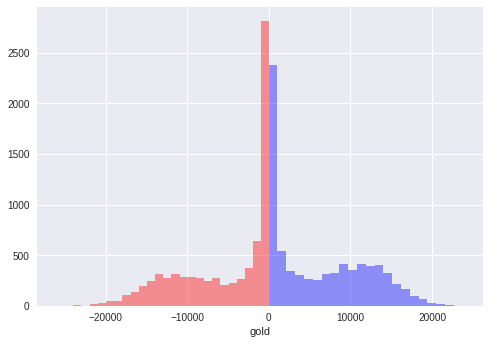

In [148]:
#Show gold difference as games progress for each side on average
sns.distplot(gold_diff.groupby('Address').gold.max(), color='blue', kde=False)
sns.distplot(gold_diff.groupby('Address').gold.min(), color='red', kde=False)
plt.show()

In [149]:
#Create a seperate dataframe for visualising game completion on average with each side
color_minute_comparison = pd.DataFrame(data={'blueWins': lol.groupby('gamelength').bResult.sum(),
                                             'redWins': lol.groupby('gamelength').rResult.sum()})

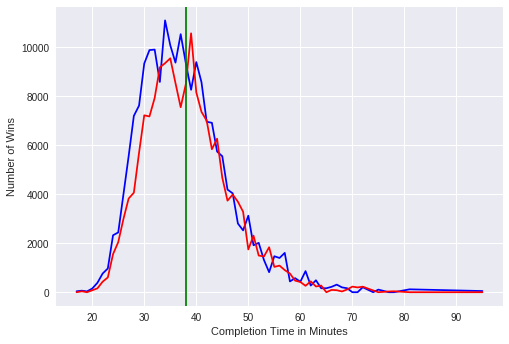

In [150]:
#Line graph showing average game completition on each side
plt.plot(color_minute_comparison.index, color_minute_comparison.blueWins, 'b-')
plt.plot(color_minute_comparison.index, color_minute_comparison.redWins, 'r-')
plt.axvline(x=lol.gamelength.mean(), color='green')
plt.xlabel('Completion Time in Minutes')
plt.ylabel('Number of Wins')
plt.show()

In [151]:
#Reassign to a specific team 'TSM'
color_minute_comparison = pd.DataFrame(data={'blueWins': tsmBlueSide.groupby('gamelength').bResult.sum(),
                                             'redWins': tsmRedSide.groupby('gamelength').rResult.sum()})

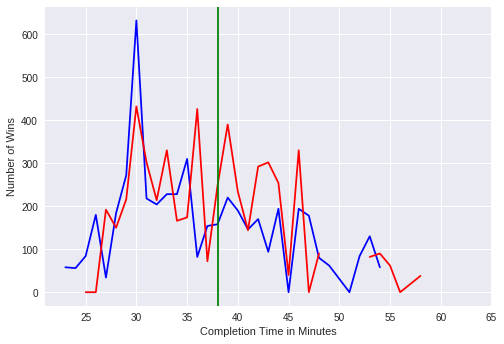

In [152]:
#Highlights the team 'TSM' winning games
#Shows they seem to win games on blue side much quicker on average than red side
plt.plot(color_minute_comparison.index, color_minute_comparison.blueWins, 'b-')
plt.plot(color_minute_comparison.index, color_minute_comparison.redWins, 'r-')
plt.axvline(x=lol.gamelength.mean(), color='green')
plt.xlabel('Completion Time in Minutes')
plt.ylabel('Number of Wins')
plt.show()